# Linear regression like a rock star

If you studied economics at any point or have used Excel you probably know what linear regression is. It is extremely useful. In order to understand it better, we are going to go on a (non-rigorous) journey through finding the two coefficients for linear regression on one variable with a toy dataset.

We are going to calculate the coefficients for linear regression with one variable by:

1. Trying various coefficients and [seeing which is optimal](#one)
1. Finding an exact solution
    1. [With linear algebra](#twoa)
    1. [With calculus](#twob)
1. Finding a precise-enough solution [numerically with gradient descent](#three)

I like to think that in a parallel universe, this is how Keith Richards is explaining linear regression.

In [1]:
import numpy as np
from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

np.set_printoptions(precision=3)

### 1. Trying various coefficients and seeing which are best <a id="one"></a>

Let's plot some random numbers for $x$, and use those same numbers with a bit of jitter for $y$, so we have an approximately linear relationship.

x, y
---

[[7.  7.4]
 [4.  4.1]
 [8.  8.5]
 [5.  5.3]
 [7.  7.1]]


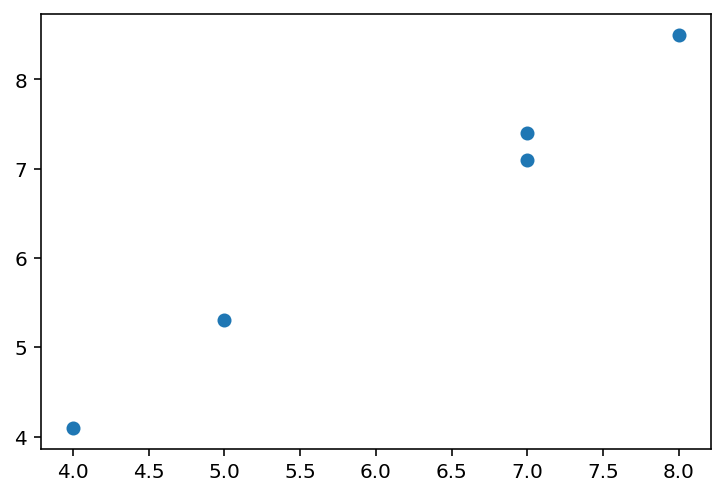

In [2]:
np.random.seed(42)

# Adds a bit of randomness
jitter_bug = lambda n: np.round(np.random.random_sample(size=n),decimals=1) # Random float [0,1) rounded to 1 dp

# Let's get x
m = 5
x = np.random.randint(1, high=10, size=m)

# y is x plus a bit of randomness
y = x + jitter_bug(m)
print('x, y\n---\n')
print(np.vstack((x,y)).T)
plt.scatter(x,y);

In high school we were told that the equation of a straight line was $y=mx+c$, and that linear regression is the line in this form which 'best fits' the data we have for $x,y$.

Now we're in machine learning land let's use $\hat y = \theta_0 + \theta_1 x$, where $\theta_0, \theta_1$ are the intercept and the gradient respectively. The hat in $\hat y$ denotes that it is an estimate, and the points along the regression line will be $x, \hat y$. 

We need some way to come up with $\hat y$; let's call this $h(x)$.

And so $\hat y = h(x) = \theta_0 + \theta_1 x$.

Note that rather than regarding $\hat y$ as our prediction for $y$, we can regard it as the $y$ that goes with the obligatory $x$ on the linear regression line.

In [3]:
hyp = lambda theta_0, theta_1, x: theta_0 + theta_1 * x

So far so good, but we have no idea how $h(x)$ will work to supply us with our $\hat y$ values which are sensible. One way to do this is to define how we will know when $h(x)$ has done the optimal job for us. We know that this will be when the line best fits the data $x,y$ and we know that $x$ will be an input into our $h(x)$ function that supplies us with $\hat y$. We also know that $h(x)$ is parameterised by $\theta_0$ and $\theta_1$, so really all we have to do is pick the best values for each of those.

Luckily for us, we have this function on hand. We will calculate the mean squared error (MSE) and we will denote this as the function $J$. $J(\theta_0, \theta_1)$ will be evaluated, and the lower the output (the MSE), the better. We call $J(\theta_0, \theta_1)$ our 'loss' function, because we want to find the values for $\theta_0, \theta_1$ that minimise it.

The MSE is simply the mean of the square of all the errors, where the error is defined as $\hat{y}_{i}- y_{i} = h_\theta (x_{i}) - y_{i}$ for the pair of $(x,y)$ values at index $i$ i.e. for any given pair in our dataset. This is then also halved by convention, which has no effect on where the minimum or maximum are.

$J(\theta_0, \theta_1) = \dfrac {1}{2m} \displaystyle \sum _{i=1}^m \left ( \hat{y}_{i}- y_{i} \right)^2 = \dfrac {1}{2m} \displaystyle \sum _{i=1}^m \left (h_\theta (x_{i}) - y_{i} \right)^2$

In [4]:
def mse(theta_0, theta_1, x, y, m):
    sum_sq_err = 0
    
    for i in range(m):
        err = hyp(theta_0, theta_1, x[i]) - y[i]
        sq_err = err ** 2
        sum_sq_err += sq_err

    return (1/(2*m)) * sum_sq_err

All we have to do now is minimise $J(\theta_0, \theta_1)$. To do this, let's first take a brute force approach, plugging in values of $-1 \leq \theta_0 \leq 1$ and $-1 \leq \theta_1 \leq 2$, calculating $J(\theta_0, \theta_1)$, and see what that looks like. This approach of minimising $J$ is called ordinary least squares (OLS).

OLS has a couple of nice properties: a perfect fit will give us $J(\theta_0, \theta_1)=0$, and there will be one minimum, so we will be able to land on one set of parameters.

In [5]:
# Arbitrary ranges for theta_0, theta_1, interpolate
resolution = 100
theta_0s = np.linspace(-2, 1, resolution)
theta_1s = np.linspace(-1, 3, resolution)

# Calculate MSEs with the different combinations of theta_0 and theta_1
mses = []
params = []

for theta_0 in theta_0s:
    for theta_1 in theta_1s:
        mses.append(mse(theta_0, theta_1, x, y, m))
        params.append((theta_0, theta_1))
        
mses = np.array(mses)

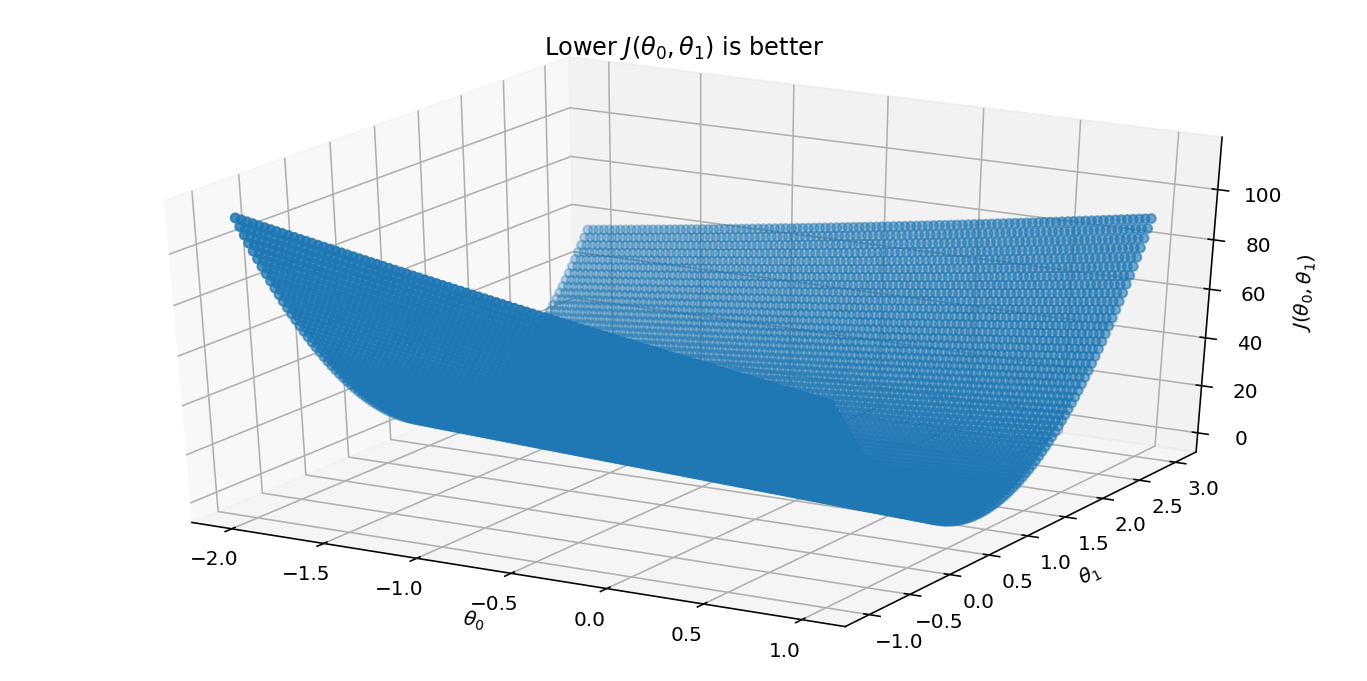

In [6]:
# plot mse for different theta_0, theta_1
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')

ax.scatter3D([theta[0] for theta in params], [theta[1] for theta in params], mses, depthshade=True, cmap='Blues')#, c=-mses, cmap='Blues') 
ax.set_title('Lower $J(θ_0,θ_1)$ is better')
ax.set_xlabel('$θ_0$')
ax.set_ylabel('$θ_1$')
ax.set_zlabel('$J(θ_0, θ_1)$')

plt.show()

Such a chart is not that easy to read the values from, but that's ok because we can ask the computer what the best values for $\theta_0, \theta_1$ are:

In [7]:
# Find best thetas we came accross i.e. those with min MSE
best_thetas = params[np.argmin(mses)]
print(best_thetas)

(-0.09090909090909083, 1.060606060606061)


Let's plot $y = \theta_0 + \theta_1 x$ as our trend line given those values of $\theta_0, \theta_1$ and see how it looks.

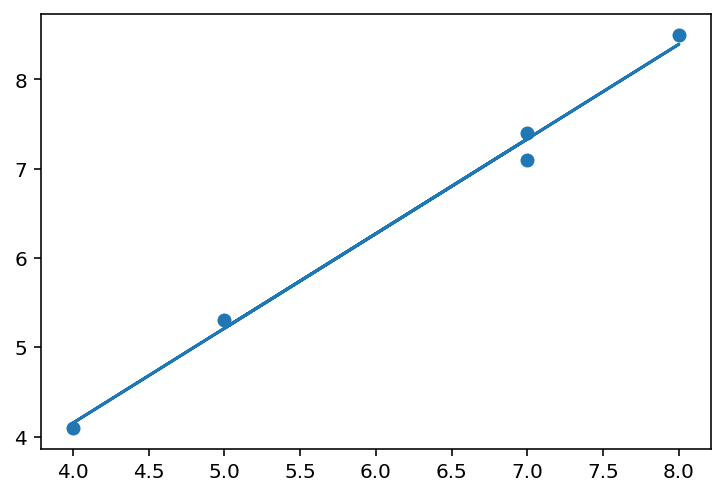

In [8]:
# Use these to plot
plt.scatter(x, y)
plt.plot(x, [hyp(best_thetas[0], best_thetas[1], x_) for x_ in x])
plt.show()

Not bad! But it doesn't look exactly right. Maybe there is a better way to find these parameters for our trend line.

### 2. A. Finding an exact solution  <a id="twoa"></a>

We can find an exact solution using the magic of linear algebra and particularly matrix inversion.

$\mathbf \theta = (\mathbf X^\top \cdot \mathbf X)^{-1} \cdot \mathbf X^\top \cdot \mathbf y$

By evaluating the right hand side of the above, we are left with a vector $\mathbf \theta$ which contains our coefficients.

This is nice because it is quick for the computer to calculate, although it won't always be possible to use this method because not all matrices can be inverted.

To do this, we first need to prepend a column vector of $1$s to our column vector $\mathbf x$ to create a matrix $\mathbf X$. This means that when we do our calculations, we will end up with a value for $\theta_0$ in addition to $\theta_1$.

We will be working with:

In [9]:
y=y.reshape(m,1) # Now a column vector
print('y =')
print(y,'\n')

X=x.reshape(m,1) # Now a column vector
X=np.hstack((np.full((m,1),1),X)) # Insert column vector of 1s for the intercept to make matrix
print('X =')
print(X)

y =
[[7.4]
 [4.1]
 [8.5]
 [5.3]
 [7.1]] 

X =
[[1 7]
 [1 4]
 [1 8]
 [1 5]
 [1 7]]


Which gives us for $\mathbf \theta$

In [10]:
thetas = np.linalg.inv(X.T @ X) @ X.T @ y
print(thetas)

[[-0.133]
 [ 1.067]]


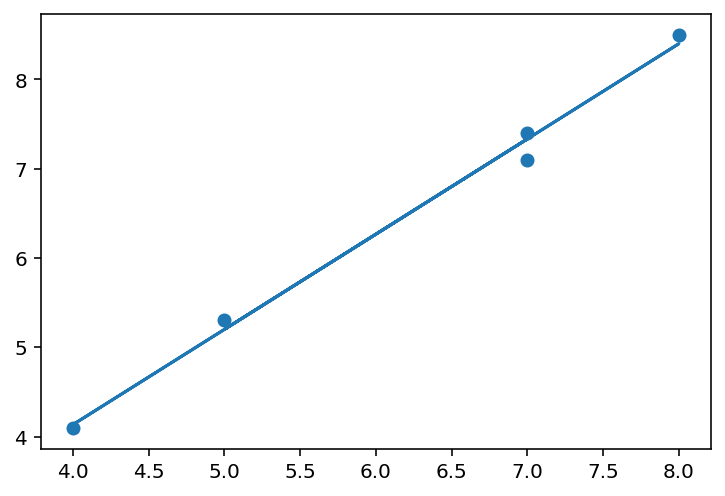

In [11]:
thetas = thetas.reshape(-1,) # Now a flat array

plt.scatter(x, y)
plt.plot(x, [hyp(thetas[0], thetas[1], x_) for x_ in x])
plt.show()
#plt.plot([0]+x.tolist(), np.hstack([hyp(thetas[0], thetas[1], x_) for x_ in [0]+[x]]).tolist()) # Same but extends to 0

When we plot the regression line with these $\theta$ it looks pretty good.

### 2. B. Finding an exact solution (again)  <a id="twob"></a>

We know that we want to find the minimum of our loss function with respect to parameters ... which sounds a lot like a calculus problem. We will not always be able to invert the matrix per the previous, and this will give us an exact solution.

We can take the partial derivative of $J$ with respect of each of $\theta_0, \theta_1$ and set each of these to 0.

$J(\theta_0, \theta_1) = \frac {1}{2m} \sum_{i=1}^{i=m} (h_{\theta}(x^{(i)}) - y^{(i)})^2 = \frac {1}{2m} \sum_{i=1}^{i=m} (\theta_0 + \theta_1 x^{(i)} - y^{(i)})^2$

$\dfrac{\partial \, \theta_0}{\partial \, J(\theta_0, \theta_1)} = \sum_{i=1}^{i=m} (\theta_0 + \theta_1 x^{(i)} - y^{(i)}) = 0$

$\dfrac{\partial \, \theta_1}{\partial \, J(\theta_0, \theta_1)} = x^{(i)} \sum_{i=1}^{i=m} (\theta_0 + \theta_1 x^{(i)} - y^{(i)}) = 0$

\[ ... \]

$\theta_0 = \frac{(\sum y) (\sum x^2) - (\sum x) (\sum xy)}{m \sum x^2 - (\sum x)^2}$

$\theta_1 = \frac{m(\sum xy) - (\sum x)(\sum y)}{m \sum x^2 - (\sum x)^2}$

And this gives us the same answer ...

In [12]:
thetas = []

# theta_0
n_ = (y.sum()*(x ** 2).sum()) - (x.sum()*(x * y.reshape(-1)).sum())
d_ = (m * (x ** 2).sum()) - (x.sum() ** 2)

thetas.append(n_/d_)

# theta_1
n_ = m * (x * y.reshape(-1)).sum() - x.sum() * y.sum()
d_ = m * (x ** 2).sum() - x.sum() ** 2

thetas.append(n_/d_)
thetas=np.array(thetas)
print(thetas)

[-0.133  1.067]


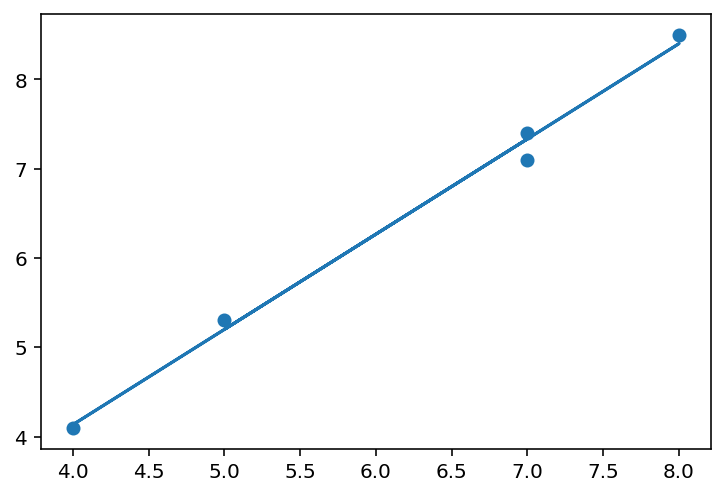

In [13]:
plt.scatter(x, y)
plt.plot(x, [hyp(thetas[0], thetas[1], x_) for x_ in x])
plt.show()

These $\theta$ provides us with a chart which looks reassuringly similar.

### 3. Gradient descent  <a id="three"></a>

We can also find the optimal values for $\theta_0, \theta_1$ using gradient descent.

To do this, we first set them to some arbitrary values, and then alter them based on the effect on $J$. 

More precisely, we pick a value for $\alpha$, the learning rate, which is kept constant and used to control the magnitude of the update. We subtract $\alpha \frac{\partial}{\partial \theta_j} J(\theta_0, \theta_1)$ from our given parameter $\theta_j$. We do this for each $\theta_j$. We then repeat this exercise, and as we get closer to the optimal values, the subtracted value reduces in magnitude, until such time as any $\theta_j$ barely changes at all.

$\theta_0 := \theta_0 - \alpha \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x_{i}) - y_{i})$

$\theta_1 := \theta_1 - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x_{i}) - y_{i}) x_{i}$

Note that in the above $:=$ means 'is assigned the value of'. Further, both of $\theta_0,\theta_1$ need to be updated before the process is repeated.

If this sounds a bit similar to Newton-Raphson from school days, it is.

If we initialise both to one, the below chart shows their convergence towards the optimal value.

In [14]:
def grad_desc(X, y, theta, alpha=0.01, n_iter=5000):
    m = len(y)
    costs = np.zeros(n_iter)
    thetas = np.zeros((n_iter, 2)) # Fix 2
    
    for i in range(n_iter):
        y_hat = X @ theta
        theta = theta - (1/m) * alpha * X.T @ (y_hat - y)
        thetas[i,:] = theta.T
        costs[i] = mse(theta[0], theta[1], x, y, m)
        
    return theta, costs, thetas

# Start values for theta, or we could just use 0
theta = np.array([[1],[1]]) # column vec
alpha = 0.01
theta, costs, thetas = grad_desc(X, y, theta)

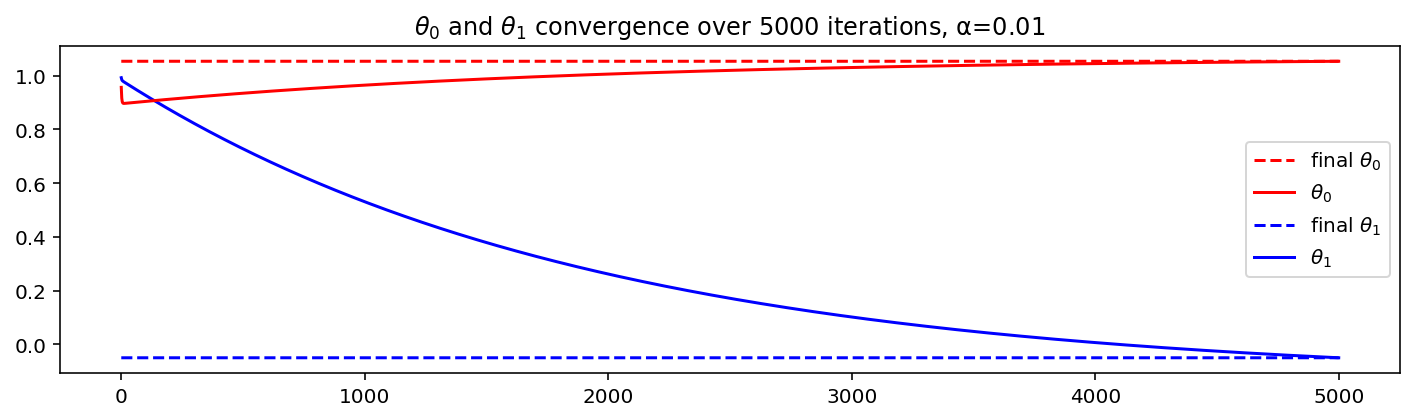

In [15]:
n = len(thetas)
xs = range(n)

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(xs, [theta[0] for theta in thetas], 'b') # converging theta_0
ax.plot(xs, [theta[1] for theta in thetas], 'r') # converging theta_1

ax.plot(xs, [theta[0]] * n, 'b--') # last theta_0
ax.plot(xs, [theta[1]] * n, 'r--') # last theta_1

ax.set_title('$θ_0$ and $θ_1$ convergence over '+str(n)+' iterations, α='+str(alpha))

#r_patch = mpatches.Patch(color='red', label='$θ_0$')
rd_line = mlines.Line2D([], [], color='red', label='final $θ_0$', linestyle='--')
r_line = mlines.Line2D([], [], color='red', label='$θ_0$')
bd_line = mlines.Line2D([], [], color='blue', label='final $θ_1$', linestyle='--')
b_line = mlines.Line2D([], [], color='blue', label='$θ_1$')

plt.legend(handles=[rd_line, r_line, bd_line, b_line])

plt.show()

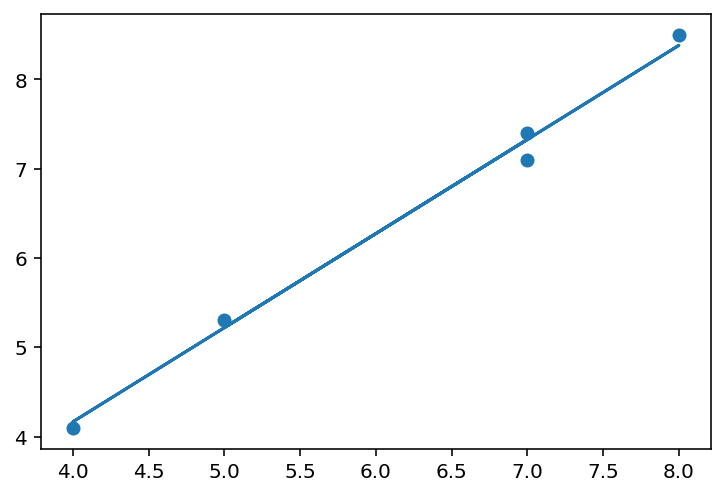

In [16]:
plt.scatter(x, y)
plt.plot(x, [hyp(theta[0], theta[1], x_) for x_ in x])
plt.show()

Looks reassuringly similar, again.

### Notes<a id="notes"></a>

**Notation**

- $x^{(i)}$ is an ‘input’ variable a.k.a. feature

- $y^{(i)}$ is an ‘output’ variable a.k.a. target

- Pair $(x^{(i)}, y^{(i)})$ is a training example

- List of $m$ training examples $(x^{(i)}, y^{(i)})$ for $i=1,\ldots,m$ is a training set

- Note: $^{(i)}$ is simply an index and not to do with exponentiation

<div>
<img src="./assets/kr.jpg" width="500"/>
</div>

> "I'll just run the numbers once I finish my Jack Daniels"